In [1]:
from pathlib import Path
parent_dir = str(Path.cwd().parent)
%cd $parent_dir

/Users/tomtalpir/Random/pyERGM


In [2]:
from utils import *
from ergm import ERGM
from metrics import *

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


# Replicating the `Sampson` example from R's ERGM
The original R ERGM paper (Hunter et al. 2008) begins with a basic example of modeling Sampson's Monestary data, which consists of a directed network with $n=18$ nodes. This network models social interactions among a group of monks (See Sampson 1969 for more details). 

In the paper, An ERGM model is fit based on the Sampson network, using `num_of_edges` as its sole feature. The R fit yields a coefficient of `-0.9071582`, which is our aim.

In [3]:
# Matrix copied manually, TODO - Create a `data` dir in our project and save as a pickle or something.
sampson_matrix = np.array(
    [[0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0], 
    [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0], 
    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1], 
    [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0], 
    [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0], 
    [1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
    [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0], 
    [1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], 
    [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0], 
    [0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0], 
    [0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0], 
    [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], 
    [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 
    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0], 
    [1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0], 
    [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], 
    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1], 
    [1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]]
)


Initial thetas - [0.46581701]
optimization started
Step 1 - lr: 0.0500000000, time from start: 0.04, sample_size: 500, sliding_grad_window_k: 20
	 Sample size increased at step 50 to 525
Step 51 - lr: 0.0450000000, time from start: 1.18, sample_size: 525, sliding_grad_window_k: 21
	 Sample size increased at step 100 to 551
Step 101 - lr: 0.0405000000, time from start: 2.50, sample_size: 551, sliding_grad_window_k: 23
Reached a confidence of 0.95 with the hotelling convergence test! DONE! 
hotelling - 0.0, hotelling_critical_value=0.003935730375712225


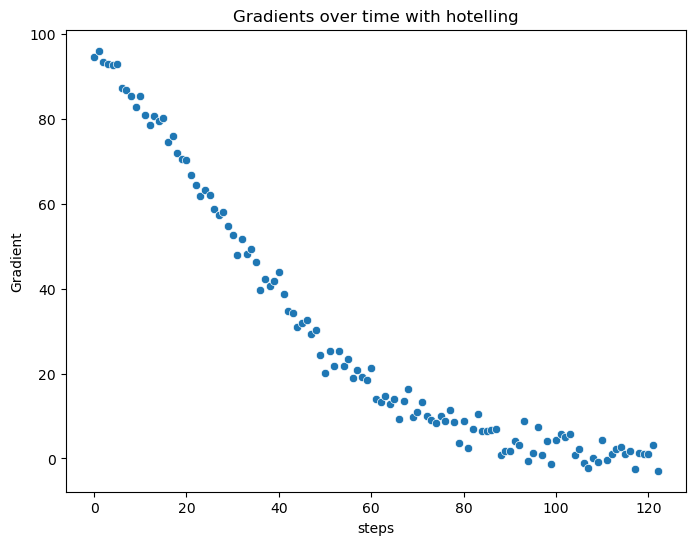

Fitted theta: [-0.88204551]


In [34]:
n = sampson_matrix.shape[0]
is_directed = True

number_of_edges_metric = NumberOfEdgesDirected() if is_directed else NumberOfEdgesUndirected()
fitted_model = ERGM(n, [number_of_edges_metric], is_directed=is_directed, sample_size=500, n_mcmc_steps=50)

convergence_criterion = "hotelling"
grads, hotelling = fitted_model.fit(sampson_matrix, lr=0.05, opt_steps=300, 
                         lr_decay_pct=0.1, steps_for_decay=50,
                         sliding_grad_window_k=20, sample_pct_growth=0.05, 
                         convergence_criterion=convergence_criterion, 
                         optimization_method="newton_raphson",
                         hotelling_confidence=0.95
                         )

grads = [x[0] for x in grads]


fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(grads, ax=ax)
ax.set(xlabel='steps', ylabel='Gradient')
ax.set_title(f"Gradients over time with {convergence_criterion}")
plt.show()

print(f"Fitted theta: {fitted_model._thetas}")

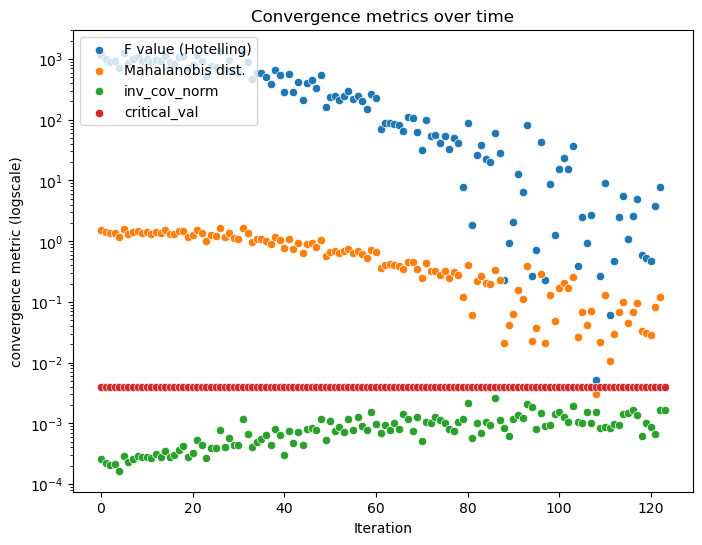

In [35]:
df = pd.DataFrame(hotelling)

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(df["hotelling_F"])
# sns.scatterplot(df["hotelling_t"])
sns.scatterplot(df["dist"])
sns.scatterplot(df["inv_cov_norm"])
sns.scatterplot(df["critical_val"])

# sns.scatterplot(df["hessian_norm"])
ax.set_yscale("log")

ax.legend(["F value (Hotelling)", "Mahalanobis dist.",  "inv_cov_norm", "critical_val",], loc="upper left")
ax.set(xlabel='Iteration', ylabel='convergence metric (logscale)')
ax.set_title("Convergence metrics over time")


plt.show()


As we can see, our model reaches a theta that is extremely close to the actual R result.

In [7]:
min(hotelling)

3.6470473599830022

10847918.021540165

## Now test a model with TotalReciprocity + NumberOfEdges

Initial thetas - [ 0.57095926 -0.14783974]
optimization started
Step 1 - lr: 0.0500000000, time from start: 0.04, sample_size: 500, sliding_grad_window_k: 20
	 Sample size increased at step 50 to 525
Step 51 - lr: 0.0450000000, time from start: 1.35, sample_size: 525, sliding_grad_window_k: 21
	 Sample size increased at step 100 to 551
Step 101 - lr: 0.0405000000, time from start: 2.72, sample_size: 551, sliding_grad_window_k: 23
	 Sample size increased at step 150 to 578
Step 151 - lr: 0.0364500000, time from start: 4.13, sample_size: 578, sliding_grad_window_k: 25
	 Sample size increased at step 200 to 606
Step 201 - lr: 0.0328050000, time from start: 5.59, sample_size: 606, sliding_grad_window_k: 27
Reached a confidence of 0.95 with the hotelling convergence test! DONE! 
hotelling - 0.042725689608504966, hotelling_critical_value=0.05129765059783868


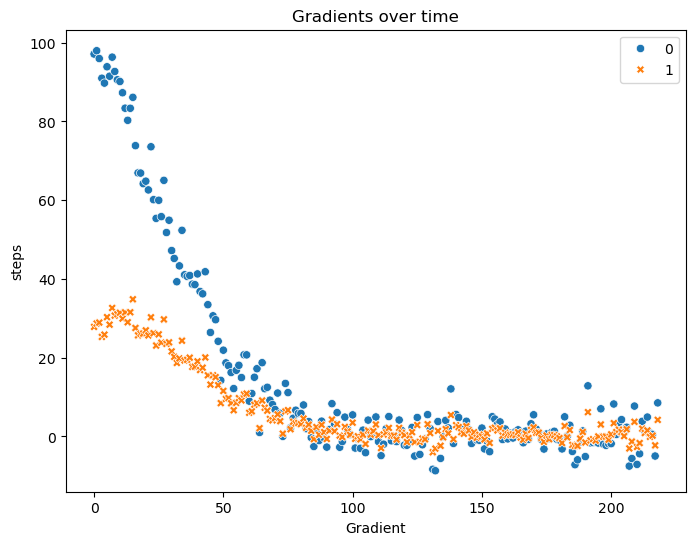

Fitted theta: [-1.7869004   2.37748828]


In [30]:
n = sampson_matrix.shape[0]
is_directed = True

number_of_edges_metric = NumberOfEdgesDirected() if is_directed else NumberOfEdgesUndirected()

estimated_p_seed = np.sum(sampson_matrix) / (n*(n-1))

metrics = [number_of_edges_metric, TotalReciprocity()]
fitted_model = ERGM(n, metrics, is_directed=is_directed, sample_size=500, n_mcmc_steps=20, seed_MCMC_proba=estimated_p_seed)

# convergence_criterion = "zero_grad_norm"
convergence_criterion = "hotelling"
grads, hotelling = fitted_model.fit(sampson_matrix, lr=0.05, opt_steps=500, 
                         lr_decay_pct=0.1, steps_for_decay=50,
                         sliding_grad_window_k=20, sample_pct_growth=0.05, 
                         convergence_criterion=convergence_criterion, 
                         optimization_method="newton_raphson",
                         hotelling_confidence=0.95
                         )

# grads, _ = fitted_model.fit(sampson_matrix, lr=1, opt_steps=400, sliding_grad_window_k=20, sample_pct_growth=0.05, lr_decay_pct=0.1, steps_for_decay=10)


fig, ax = plt.subplots(figsize=(8, 6))

sns.scatterplot(grads, ax=ax)
ax.set(xlabel='Gradient', ylabel='steps')
ax.set_title("Gradients over time")

plt.show()

print(f"Fitted theta: {fitted_model._thetas}")

#### Took a while (~1 minute), but results are pretty close!
True results in R -
* $\theta_1 = -1.7625$
* $\theta_2 = 2.3132$

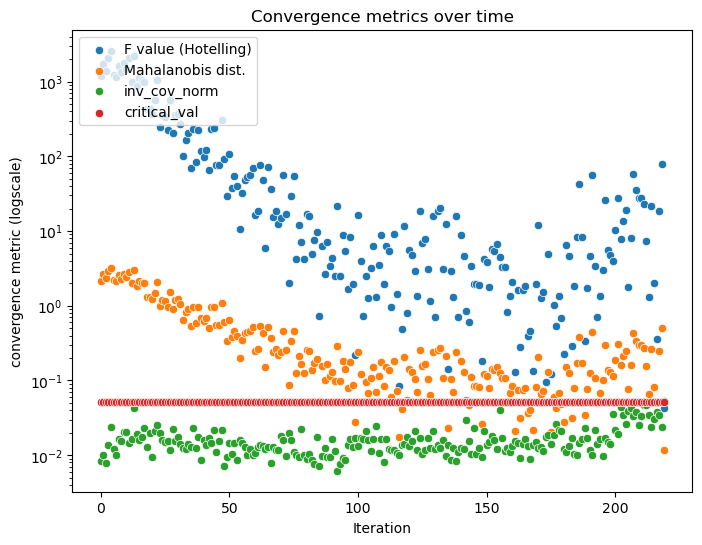

In [31]:
df = pd.DataFrame(hotelling)

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(df["hotelling_F"])
# sns.scatterplot(df["hotelling_t"])
sns.scatterplot(df["dist"])
sns.scatterplot(df["inv_cov_norm"])
sns.scatterplot(df["critical_val"])

# sns.scatterplot(df["hessian_norm"])
ax.set_yscale("log")

ax.legend(["F value (Hotelling)", "Mahalanobis dist.",  "inv_cov_norm", "critical_val",], loc="upper left")
ax.set(xlabel='Iteration', ylabel='convergence metric (logscale)')
ax.set_title("Convergence metrics over time")


plt.show()


## And finally we test the full $p_1$ model

Initial thetas - [-0.55569216  0.25370329 -0.04810213 -0.65924829  0.49037706  0.08151397
 -0.82493531  0.27589133 -0.28211439  0.88776414 -0.57187046  0.3289238
  0.96322517  0.31094013  0.71465726 -0.68727119  0.98553579  0.29039467
 -0.19616242  0.61875503  0.12332683 -0.72493455 -0.81768444  0.12625656
  0.70678594  0.52423145  0.87774747  0.95451411  0.20910663 -0.82945075
  0.97059102  0.54897667 -0.80515273 -0.61662495  0.96724157 -0.76071418]
optimization started
Step 1 - lr: 0.0500000000, time from start: 0.57, sample_size: 10000, sliding_grad_window_k: 20
Step 26 - lr: 0.0450000000, time from start: 14.31, sample_size: 10000, sliding_grad_window_k: 21
Step 51 - lr: 0.0405000000, time from start: 27.76, sample_size: 10000, sliding_grad_window_k: 23
Step 76 - lr: 0.0364500000, time from start: 41.18, sample_size: 10000, sliding_grad_window_k: 25
Step 101 - lr: 0.0328050000, time from start: 54.63, sample_size: 10000, sliding_grad_window_k: 27
Step 126 - lr: 0.0295245000, time f

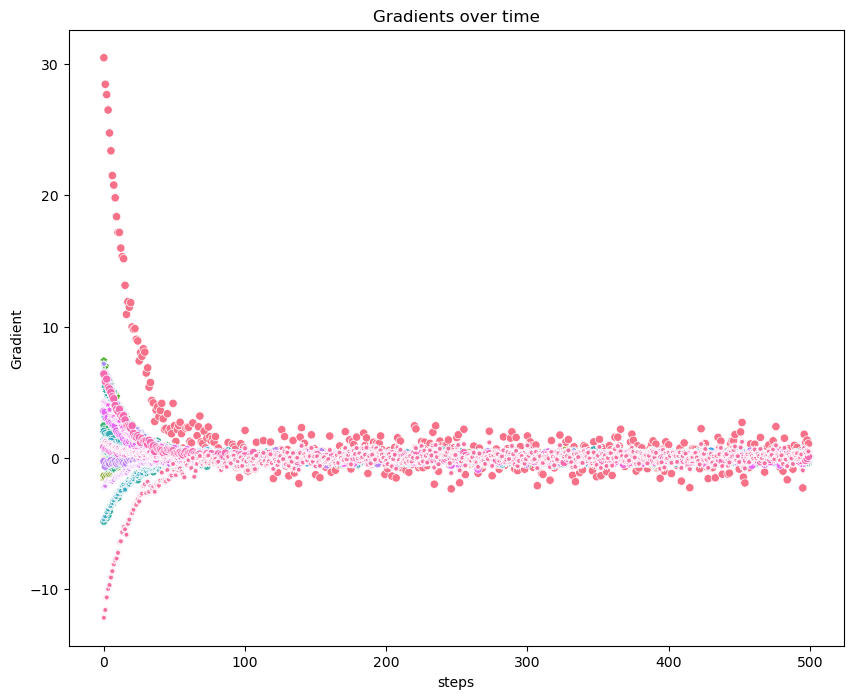

Fitted theta: [-1.19689024 -0.23901129  1.47092341  0.37826401  0.15388015  1.27533237
  0.64196491  1.3985729   0.67280044  2.12666633  1.46968128 -0.1252438
 -0.21626075  0.63772602  1.90619064  1.46836426  1.26857757  1.89839839
 -0.16722787 -3.07259712 -1.76404759 -0.84569351 -3.44637902 -1.60875348
 -2.32151875 -2.23810766 -3.95352772 -3.07216337 -0.98372103 -1.49480459
 -1.61223299 -3.32395429 -3.07106679 -3.45860144 -3.31531533  3.71913926]


In [10]:
n = sampson_matrix.shape[0]
is_directed = True



estimated_p_seed = np.sum(sampson_matrix) / (n*(n-1))

metrics = [NumberOfEdgesDirected(), OutDegree(), InDegree(), TotalReciprocity()]

fitted_model = ERGM(n, metrics, is_directed=is_directed, sample_size=10000, n_mcmc_steps=20, seed_MCMC_proba=estimated_p_seed)

# convergence_criterion = "zero_grad_norm"
convergence_criterion = "hotelling"

hotelling_conf = 0.9
grads, hotelling = fitted_model.fit(sampson_matrix, lr=0.05, opt_steps=500, 
                         lr_decay_pct=0.1, steps_for_decay=25,
                         sliding_grad_window_k=20, sample_pct_growth=0.05, 
                         convergence_criterion=convergence_criterion, 
                         optimization_method="newton_raphson",
                         hotelling_confidence=hotelling_conf,
                         )

fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(grads, ax=ax, legend=False)
ax.set(xlabel='steps', ylabel='Gradient')
ax.set_title("Gradients over time")
plt.show()

print(f"Fitted theta: {fitted_model._thetas}")

In [50]:
df["hotelling_F"].min()

2.053797499134223

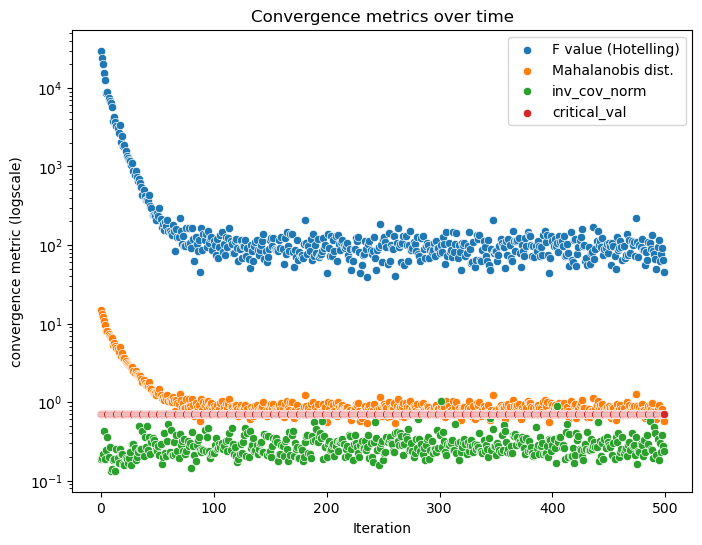

In [8]:
df = pd.DataFrame(hotelling)

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(df["hotelling_F"])
# sns.scatterplot(df["hotelling_t"])
sns.scatterplot(df["dist"])
sns.scatterplot(df["inv_cov_norm"])
sns.scatterplot(df["critical_val"])

# sns.scatterplot(df["hessian_norm"])
ax.set_yscale("log")

ax.legend(["F value (Hotelling)", "Mahalanobis dist.",  "inv_cov_norm", "critical_val",], loc="upper right")
ax.set(xlabel='Iteration', ylabel='convergence metric (logscale)')
ax.set_title("Convergence metrics over time")


plt.show()


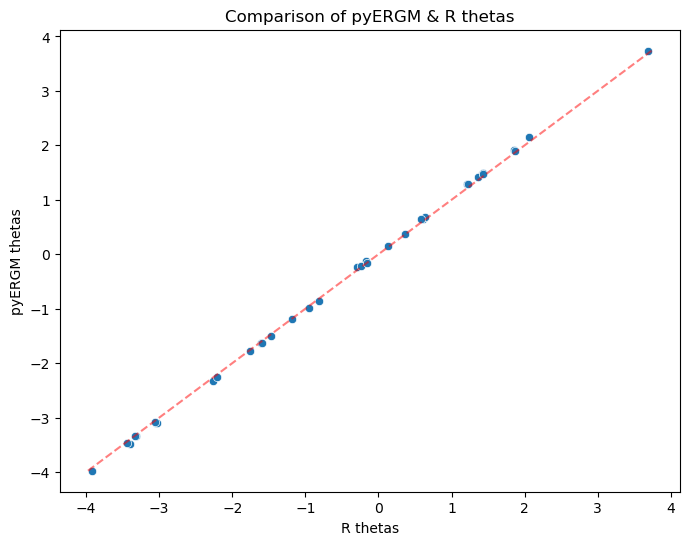

In [9]:
true_values = {"edges":      -1.1761, "sender2":    -0.2945, "sender3":     1.4141, "sender4":     0.3662, "sender5":     0.1315, "sender6":     1.2148, "sender7":     0.6055,
"sender8":     1.3609, "sender9":     0.6402, "sender10":    2.0639, "sender11":    1.4355, "sender12":   -0.1681, "sender13":   -0.2322, "sender14":    0.5841, "sender15":    1.8600,
"sender16":    1.4317, "sender17":    1.2211, "sender18":    1.8724, "receiver2":  -0.1522, "receiver3":  -3.0453, "receiver4":  -1.7596, "receiver5":  -0.8198, "receiver6":  -3.3922,
"receiver7":  -1.6074, "receiver8":  -2.2656, "receiver9":  -2.2069, "receiver10": -3.9189, "receiver11": -3.0257, "receiver12": -0.9457, "receiver13": -1.4749, "receiver14": -1.5950,
"receiver15": -3.3147, "receiver16": -3.0567, "receiver17": -3.4436, "receiver18": -3.3239, "mutual":       3.6918
}

true_predictions = np.array(list(true_values.values()))
fitted_thetas = fitted_model._thetas

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=true_predictions, y=fitted_thetas)

min_x = min(min(true_predictions), min(fitted_thetas))
max_x = max(max(true_predictions), max(fitted_thetas))

sns.lineplot(x=[min_x, max_x], y=[min_x, max_x], color="red", linestyle="--", alpha=0.5)
ax.set(xlabel='R thetas', ylabel='pyERGM thetas')
ax.set_title("Comparison of pyERGM & R thetas")
plt.show()


<Axes: ylabel='critical_val'>

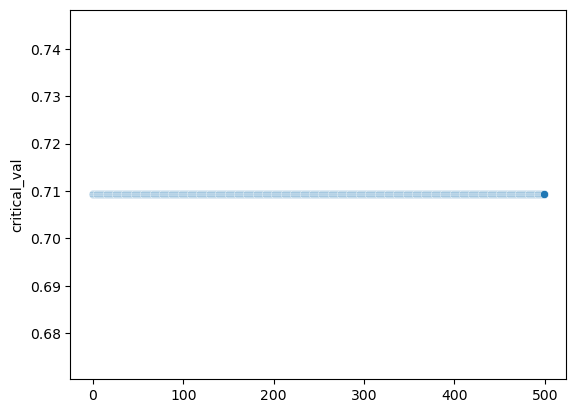

In [40]:
sns.scatterplot(df["critical_val"])

Initial thetas - [ 0.1428232  -0.41869081  0.90423759 -0.43476075  0.33906908 -0.3184857
  0.55628699 -0.28190521 -0.27319143 -0.44047184 -0.87027567  0.68196958
 -0.16878906  0.40668376 -0.35104826 -0.31156689  0.63554175 -0.69658438
  0.10665391 -0.32544066 -0.79685391 -0.19586834  0.72913534 -0.45833901
 -0.72141654 -0.92377077 -0.97841534  0.51689821  0.87088018  0.4293113
  0.83490048  0.91445323 -0.57811144 -0.66034657 -0.99459911  0.93627012
 -0.87041671 -0.10605143 -0.58042166 -0.6189179   0.95656413  0.02696338
  0.96902228  0.13585657  0.80084931 -0.52493869 -0.77596315 -0.06178379
  0.3235456  -0.77608537  0.80650493 -0.63740271 -0.96352001 -0.29896032
  0.24749191  0.81393262  0.20190813  0.79500904 -0.09396069 -0.69801827]
optimization started
Step 1 - lr: 0.4950000000, time from start: 6.91, window_grad: 19.29
Step 2 - lr: 0.4900500000, time from start: 13.43, window_grad: 14.43
Step 3 - lr: 0.4851495000, time from start: 19.90, window_grad: 11.50
Step 4 - lr: 0.480298005

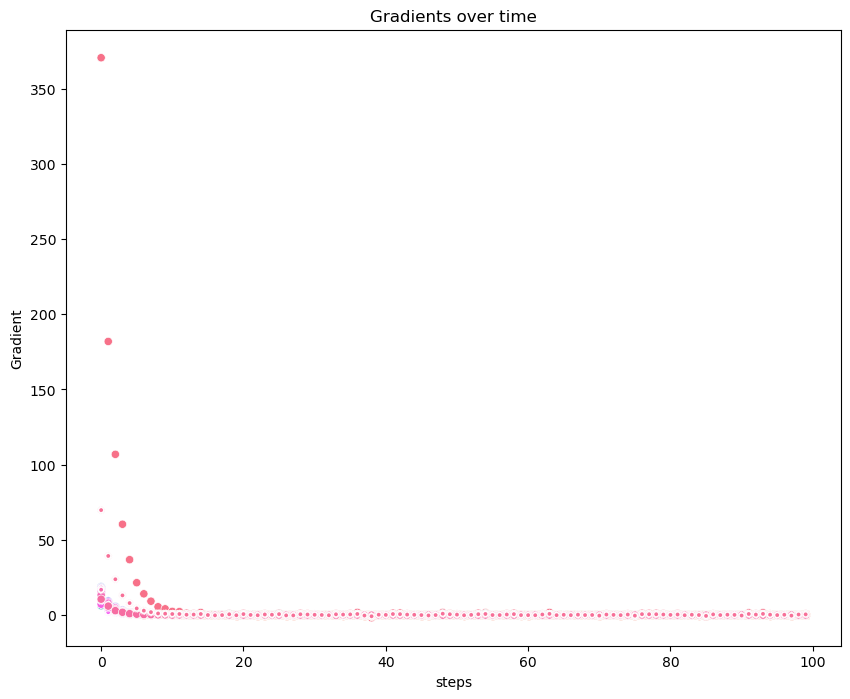

Fitted theta: [-1.68505305e+01  1.91613801e+00  3.92301781e-01  1.43292488e+01
  1.61756203e+01 -6.42362127e-01  3.68007485e+00  1.53561824e+01
  3.17078223e+00  1.53777752e+01  1.20269960e+01  3.47690836e+00
  1.53737184e+01  1.53779930e+01  1.37073496e+01  4.05153396e+00
  2.83919113e+00  4.38246977e+00  1.36673233e+01  2.73018642e+00
  1.09560805e-01  1.54678418e+01  1.36140858e+01  1.53751735e+01
 -5.37483742e-01  1.53587169e+01 -1.13570175e-02  3.01819404e+00
  1.53726801e+01 -2.25952982e-01 -1.07642037e+01 -8.46966565e-01
 -1.79328913e+00 -1.53615411e+01 -7.91136045e-01 -1.13557392e+01
 -1.54388236e+01 -1.07637087e+01 -1.48019663e+01 -7.42624551e-01
 -1.09138872e+01 -1.47926658e+01 -1.44350058e+01 -2.44403456e+00
 -1.09810900e+01 -1.17349417e+01 -1.10220328e+01 -2.50151086e+00
 -1.20955502e+01 -8.37069647e-01 -3.95595015e+00 -2.56268607e+00
 -1.45270717e+01 -1.92747572e-02 -1.56285552e+01 -8.15955720e-01
 -1.05411116e+01 -1.46159377e+01 -8.15693922e-01  9.32810865e+00]


In [7]:
gals_data = pd.read_csv("./connectome_data.csv")
gals_data = gals_data.drop("Unnamed: 0", axis=1)

W = gals_data.values

W = W[:30, :30]

n = W.shape[0]
is_directed = True

estimated_p_seed = np.sum(W) / (n*(n-1))

# metrics = [NumberOfEdgesDirected(), TotalReciprocity()]
metrics = [NumberOfEdgesDirected(), OutDegree(), InDegree(), TotalReciprocity()]

fitted_model = ERGM(n, metrics, is_directed=is_directed, sample_size=100000, n_mcmc_steps=n, seed_MCMC_proba=estimated_p_seed)

# # convergence_criterion = "zero_grad_norm"
convergence_criterion = "hotelling"

hotelling_conf = 0.9
grads, hotelling = fitted_model.fit(W, lr=0.5, opt_steps=100, 
                         lr_decay_pct=0.01, steps_for_decay=1,
                         sliding_grad_window_k=5, sample_pct_growth=0.05, 
                         convergence_criterion=convergence_criterion, 
                         optimization_method="newton_raphson",
                         hotelling_confidence=hotelling_conf,
                         
                         )

fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(grads, ax=ax, legend=False)
ax.set(xlabel='steps', ylabel='Gradient')
ax.set_title("Gradients over time")
plt.show()

print(f"Fitted theta: {fitted_model._thetas}")

In [7]:
df

,dist,hotelling_F,critical_val,inv_cov_norm,inv_hessian_norm
0,1.511810,11426.702938,0.105362,0.000254,0.016926
1,1.470946,10817.329151,0.105362,0.000262,0.013969
2,1.132893,6416.588952,0.105362,0.000124,0.016196
3,1.075460,5782.491057,0.105362,0.000102,0.012729
4,1.230048,7564.338370,0.105362,0.000114,0.014183
...,...,...,...,...,...
95,1.257223,7902.263932,0.105362,0.000138,0.012573
96,1.173751,6887.772751,0.105362,0.000151,0.015951
97,1.407260,9900.915087,0.105362,0.000237,0.016778
98,1.376713,9475.745038,0.105362,0.000194,0.013799


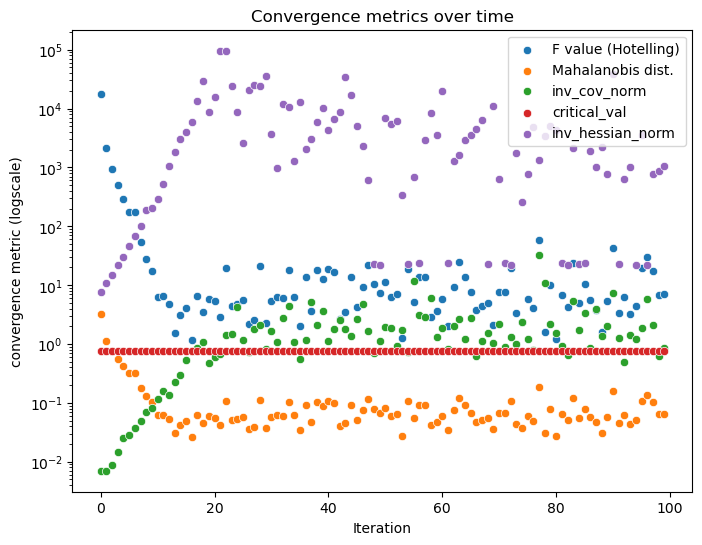

In [8]:
df = pd.DataFrame(hotelling)

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(df["hotelling_F"])
# sns.scatterplot(df["hotelling_t"])
sns.scatterplot(df["dist"])
sns.scatterplot(df["inv_cov_norm"])
sns.scatterplot(df["critical_val"])

sns.scatterplot(df["inv_hessian_norm"])
ax.set_yscale("log")

ax.legend(["F value (Hotelling)", "Mahalanobis dist.",  "inv_cov_norm", "critical_val", "inv_hessian_norm"], loc="upper right")
ax.set(xlabel='Iteration', ylabel='convergence metric (logscale)')
ax.set_title("Convergence metrics over time")


plt.show()


<Axes: >

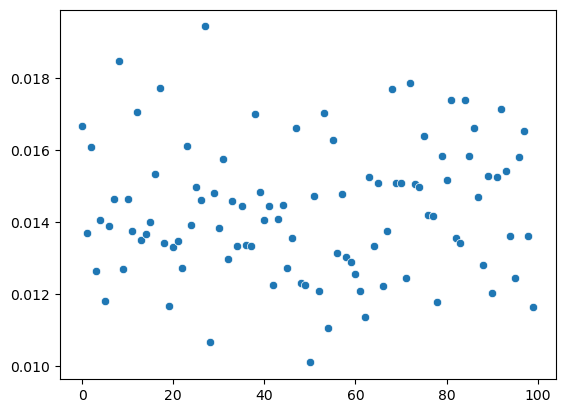

In [12]:
sns.scatterplot(df["inv_hessian_norm"] - df["inv_cov_norm"])